# Лабораторна №4, Вільчинська О-О.О. , прийняв Горун Павло

# Хід Роботи

## Load and Preprocess Data

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Input
gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_virtual_device_configuration(gpus[0],
   [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16000)])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, UpSampling2D
from keras.regularizers import l2

In [ ]:
from keras.datasets import mnist, fashion_mnist
import numpy as np

# Load MNIST and Fashion-MNIST datasets
(x_train_mnist, _), (x_test_mnist, _) = mnist.load_data()
(x_train_fmnist, _), (x_test_fmnist, _) = fashion_mnist.load_data()

# Normalize the images to [0, 1] and reshape for fully connected networks
x_train_mnist = x_train_mnist.astype('float32') / 255.0
x_test_mnist = x_test_mnist.astype('float32') / 255.0
x_train_mnist = np.reshape(x_train_mnist, (len(x_train_mnist), 28, 28, 1))
x_test_mnist = np.reshape(x_test_mnist, (len(x_test_mnist), 28, 28, 1))

x_train_fmnist = x_train_fmnist.astype('float32') / 255.0
x_test_fmnist = x_test_fmnist.astype('float32') / 255.0
x_train_fmnist = np.reshape(x_train_fmnist, (len(x_train_fmnist), 28, 28, 1))
x_test_fmnist = np.reshape(x_test_fmnist, (len(x_test_fmnist), 28, 28, 1))


In [ ]:
x_test_mnist.shape

(10000, 28, 28, 1)

## Function

In [ ]:
import matplotlib.pyplot as plt

def plot_images(original, noisy, reconstructed_deep, reconstructed_conv, num_images=10):
    plt.figure(figsize=(18, 6))

    for i in range(num_images):
        # Original images
        plt.subplot(4, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Noisy images
        plt.subplot(4, num_images, i + 1 + num_images)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Reconstructed images
        plt.subplot(4, num_images, i + 1 + num_images*2 )
        plt.imshow(reconstructed_deep[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_images, i + 1 + num_images*3 )
        plt.imshow(reconstructed_conv[i].reshape(28, 28), cmap='gray')
        plt.axis('off')


    plt.show()


def plot_predict_images(original, predict, num_images=10):
    plt.figure(figsize=(18, 6))

    for i in range(num_images):
        # Original images
        plt.subplot(4, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Noisy images
        plt.subplot(4, num_images, i + 1 + num_images)
        plt.imshow(predict[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.show()

In [ ]:
def plot_visualization(history):
    # Visualize the training and validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
from collections import defaultdict
def log_model_info(model, epochs, history, test_loss, results):
    model_info = defaultdict(list)

    # Додаємо основні параметри
    for layer in model.layers:
        config = layer.get_config()

        # Збираємо інформацію про кожен шар
        if 'Conv2D' in layer.__class__.__name__:
            model_info['Conv2D_filters'].append(config['filters'])
            model_info['Conv2D_kernel_size'].append(config['kernel_size'])
        elif 'Dense' in layer.__class__.__name__:
            model_info['Dense_units'].append(config['units'])
        elif 'Dropout' in layer.__class__.__name__:
            model_info['Dropout_rate'].append(config['rate'])
        elif 'BatchNormalization' in layer.__class__.__name__:
            model_info['BatchNormalization'].append(True)
        elif 'MaxPooling2D' in layer.__class__.__name__:
            model_info['MaxPooling2D'].append(config['pool_size'])

    # Додаємо оптимізатор, кількість епох, кількість параметрів
    model_info['optimizer'] = model.optimizer.name
    model_info['learning_rate'] =  float(model.optimizer.learning_rate.numpy())
    model_info['epochs'] = epochs
    model_info['train_loss'] = history.history['loss'][-1]
    model_info['val_loss'] = history.history['val_loss'][-1]
    model_info['test_loss'] = test_loss
    model_info['total_params'] = model.count_params()

    # Додаємо результати у загальний список
    results.append(model_info)

## Training

In [ ]:
results = []
def training(autoencoder, train_X,  X_test, epochs=10):
      print(f"Training model CNN")

      autoencoder.compile(optimizer='adam', loss='mse', metrics=['binary_crossentropy'])

      reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.5,
                                min_lr=1e-6)
      history = autoencoder.fit(train_X, train_X,
                                epochs=epochs,
                                batch_size=256,
                                validation_data=(X_test, X_test),
                                callbacks=[reduce_lr])
      plot_visualization(history)
      predict_data = autoencoder.predict(X_test)
      plot_predict_images(X_test, predict_data)

      test_loss, metrics = autoencoder.evaluate(X_test, X_test)

      print(f"Metrics MAE: {metrics}, test loss: {test_loss}")
      log_model_info(autoencoder, epochs, history, test_loss, results)
      print("-" * 60)

## Autoencoder

### Deep Autoencoder (Fully Connected)

In [ ]:
def deep_autoencoder(input_shape=(28, 28, 1), activation='relu'):
    model = Sequential()

    # Encoder
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation=activation))
    model.add(Dense(256, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(32, activation=activation))

    # Decoder
    model.add(Dense(64, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(256, activation=activation))
    model.add(Dense(512, activation=activation))
    model.add(Dense(28 * 28, activation='sigmoid'))
    model.add(Reshape((28, 28, 1)))
    model.summary()
    return model




### Convolutional Autoencoder

Nearest Neighbor (найближчий сусід)

Цей метод дублює найближчі пікселі при збільшенні розмірів зображення.
Як працює: Кожен піксель у вихідному зображенні просто копіюється у своїх сусідів у вихідному шарі, тобто кожен піксель, створений шляхом upsampling, отримає значення найближчого до нього пікселя.
Переваги: Швидкий і обчислювально легкий метод, але якість зображення може страждати через створення чітких блоків.
Недоліки: Часто призводить до "блочних" артефактів, коли масштабування відбувається значно.

---


Bilinear Interpolation (білінійна інтерполяція)

Цей метод інтерполяції використовує середнє значення з декількох сусідніх пікселів.
Як працює: Білінійна інтерполяція розглядає значення кожного нового пікселя як зважене середнє його найближчих сусідів у 2D (по рядках і стовпцях).
Переваги: Зазвичай створює м’які, плавні переходи, уникаючи "блочних" ефектів, як у nearest neighbor.
Недоліки: Може розмити деталі зображення, особливо у випадку різких контурів.


`результати експериментів:   bce     мсе `
---
модель 64-32-32-64   bce = 0.067

---
kernel_initializer  0.0969 = bce    0.0197 = мсе

---
kernel_initializer = he_uniform  0.068 = bce    0.0197 = мсе

---
kernel_initializer = he_normal  0.066 = bce

---
kernel_initializer = glorot_normal  0.067 = bce

---
kernel_regularizer=l2 = 0.001   0.0953 = bce    0.0182 = мсе

---
kernel_regularizer=l2 = 0.01    мсе = 0.0598

---
kernel_regularizer=l2 = 0.0001    мсе = 0.0069

---
activation = 'LeakyRelu'    мсе = 0.0068

---
UpSampling2D = 'nearest'    мсе = 0.007

---
UpSampling2D = 'bilinear'    мсе = 0.009

---
add BatchNormalization    mse = 0.0046










In [ ]:

def conv_autoencoder(input_shape=(28, 28, 1), interpolation='nearest'):
    model = Sequential()

    # Encoder
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.add(UpSampling2D((2, 2), interpolation = interpolation))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.add(UpSampling2D((2, 2), interpolation = interpolation))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.summary()
    return model



### complete_conv_autoencoder

In [ ]:

def complete_conv_autoencoder(input_shape=(28, 28, 1), interpolation='nearest'):
    model = Sequential()

    # Encoder
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001), input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))

    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))

    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))

    model.add(UpSampling2D((2, 2), interpolation = interpolation))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))

    model.add(UpSampling2D((2, 2), interpolation = interpolation))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.summary()
    return model



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,161 (547.50 KB)

 Trainable params: 139,969 (546.75 KB)

 Non-trainable params: 192 (768.00 B)

Training model CNN
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - binary_crossentropy: 2.1531 - loss: 0.1793 - val_binary_crossentropy: 0.1719 - val_loss: 0.0724 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - binary_crossentropy: 0.0988 - loss: 0.0435 - val_binary_crossentropy: 0.1652 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - binary_crossentropy: 0.0735 - loss: 0.0220 - val_binary_crossentropy: 0.1281 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - binary_crossentropy: 0.0714 - loss: 0.0147 - val_binary_crossentropy: 0.0968 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - binary_crossentropy: 0.0697 - loss: 0.0105 - val_binary_crossentropy: 0.0832 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - binary_crossentropy: 0.0694 - loss: 0.0083 - val

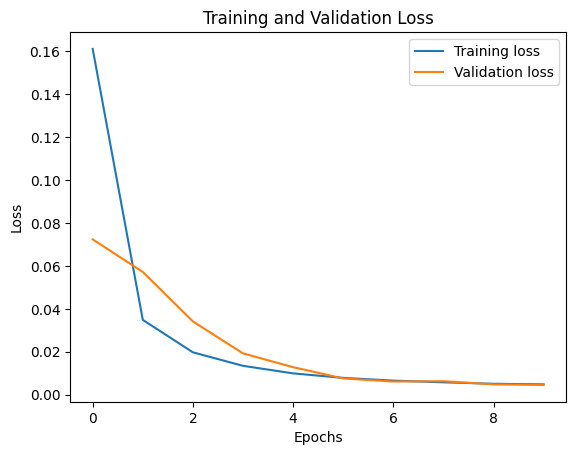

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


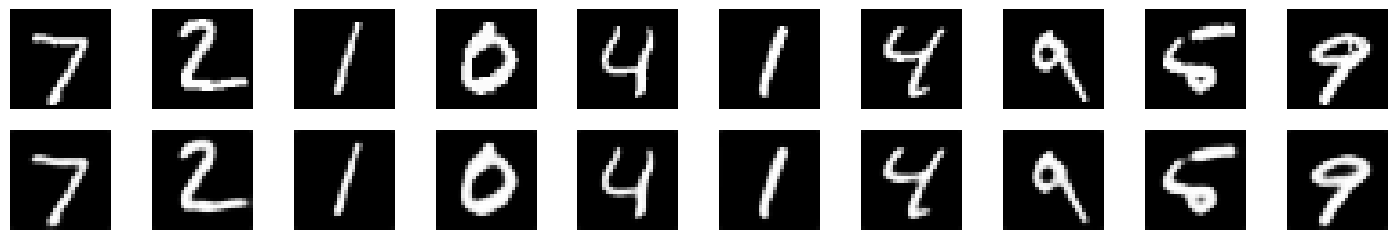

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_crossentropy: 0.0662 - loss: 0.0046
Metrics MAE: 0.06692929565906525, test loss: 0.0045608156360685825
------------------------------------------------------------


In [ ]:

complete_conv_ae = complete_conv_autoencoder(interpolation='nearest')
training(complete_conv_ae, x_train_mnist,  x_test_mnist)

## MNIST DATASET

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,153,712 (4.40 MB)

 Trainable params: 1,153,712 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

Training model CNN
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - binary_crossentropy: 0.4055 - loss: 0.0863 - val_binary_crossentropy: 0.1822 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.1685 - loss: 0.0304 - val_binary_crossentropy: 0.1406 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.1373 - loss: 0.0218 - val_binary_crossentropy: 0.1272 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.1261 - loss: 0.0185 - val_binary_crossentropy: 0.1188 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.1188 - loss: 0.0165 - val_binary_crossentropy: 0.1132 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.1131 - loss: 0.0149 - val_binary_

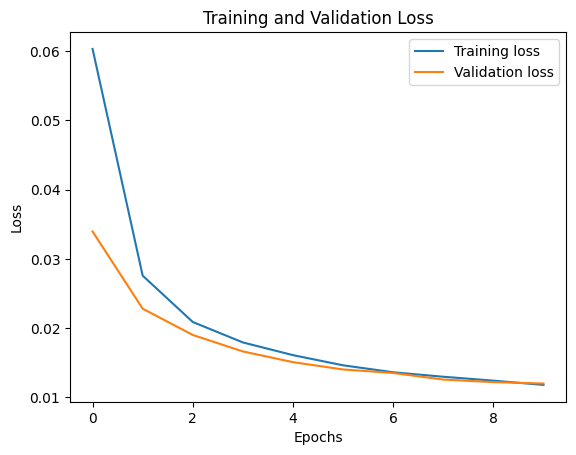

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


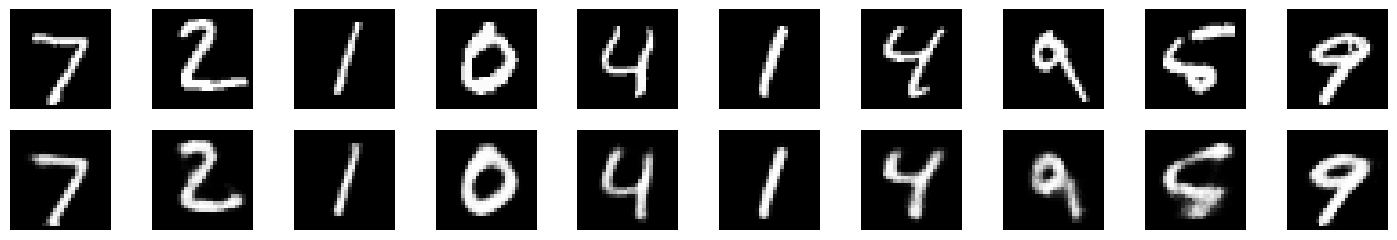

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_crossentropy: 0.1012 - loss: 0.0123
Metrics MAE: 0.10144597291946411, test loss: 0.012004886753857136
------------------------------------------------------------


In [ ]:

deep_ae = deep_autoencoder()
training(deep_ae, x_train_mnist,  x_test_mnist)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_12 (UpSampling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_13 (UpSampling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,809 (186.75 KB)

 Trainable params: 47,617 (186.00 KB)

 Non-trainable params: 192 (768.00 B)

Training model CNN
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - binary_crossentropy: 0.1599 - loss: 0.0661 - val_binary_crossentropy: 0.1083 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - binary_crossentropy: 0.0767 - loss: 0.0261 - val_binary_crossentropy: 0.0960 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_crossentropy: 0.0729 - loss: 0.0160 - val_binary_crossentropy: 0.0925 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - binary_crossentropy: 0.0713 - loss: 0.0106 - val_binary_crossentropy: 0.0849 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - binary_crossentropy: 0.0701 - loss: 0.0076 - val_binary_crossentropy: 0.0791 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_crossentropy: 0.0693 - loss: 0.0059 - val_b

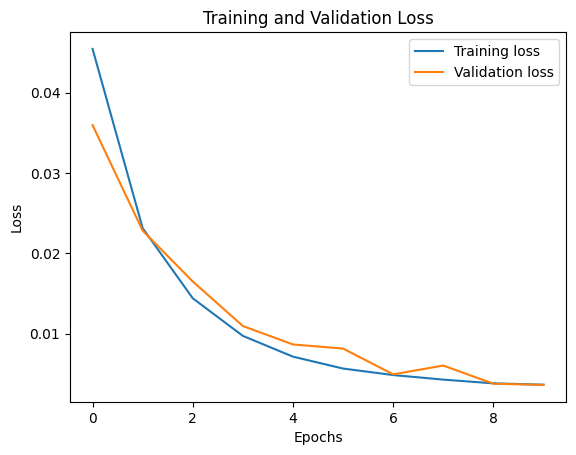

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


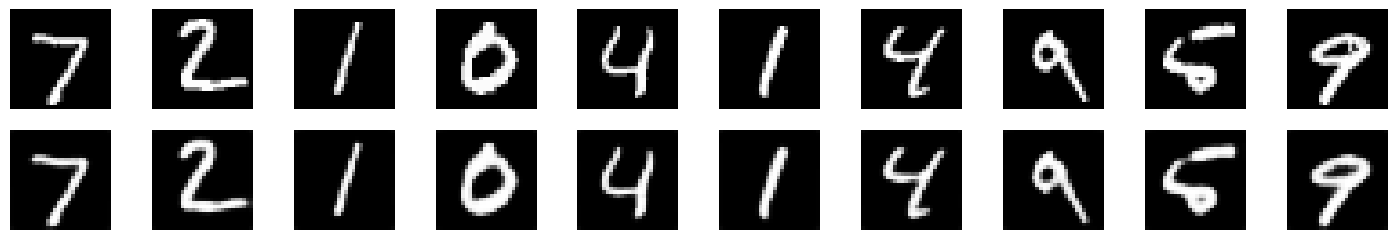

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_crossentropy: 0.0670 - loss: 0.0036
Metrics MAE: 0.06762485951185226, test loss: 0.0036145392805337906
------------------------------------------------------------


In [ ]:

conv_ae = conv_autoencoder(interpolation='nearest')
training(conv_ae, x_train_mnist,  x_test_mnist)

In [ ]:
df = pd.DataFrame(results)
df

,Conv2D_filters,Conv2D_kernel_size,BatchNormalization,MaxPooling2D,optimizer,learning_rate,epochs,train_loss,val_loss,test_loss,total_params,Dense_units
0,"[64, 64, 32, 32, 32, 32, 64, 64, 1]","[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3...","[True, True]","[(2, 2), (2, 2)]",adam,0.0005,10,0.004822,0.004561,0.004561,140161,NaN
1,NaN,NaN,NaN,NaN,adam,0.0010,10,0.011803,0.012005,0.012005,1153712,"[512, 256, 128, 64, 32, 64, 128, 256, 512, 784]"
2,"[64, 32, 32, 64, 1]","[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]","[True, True]","[(2, 2), (2, 2)]",adam,0.0005,10,0.003644,0.003615,0.003615,47809,NaN


### без BatchNormalization

In [ ]:

def conv_autoencoder(input_shape=(28, 28, 1), interpolation='nearest'):
    model = Sequential()

    # Encoder
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001), input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.add(UpSampling2D((2, 2), interpolation = interpolation))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.add(UpSampling2D((2, 2), interpolation = interpolation))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)))
    model.summary()
    return model



Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_69 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_24 (UpSampling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_25 (UpSampling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,425 (185.25 KB)

 Trainable params: 47,425 (185.25 KB)

 Non-trainable params: 0 (0.00 B)

Training model CNN
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - binary_crossentropy: 0.1774 - loss: 0.0713 - val_binary_crossentropy: 0.0805 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_crossentropy: 0.0797 - loss: 0.0274 - val_binary_crossentropy: 0.0752 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - binary_crossentropy: 0.0757 - loss: 0.0187 - val_binary_crossentropy: 0.0737 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_crossentropy: 0.0743 - loss: 0.0140 - val_binary_crossentropy: 0.0729 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - binary_crossentropy: 0.0736 - loss: 0.0113 - val_binary_crossentropy: 0.0726 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - binary_crossentropy: 0.0732 - loss: 0.0096 - val_b

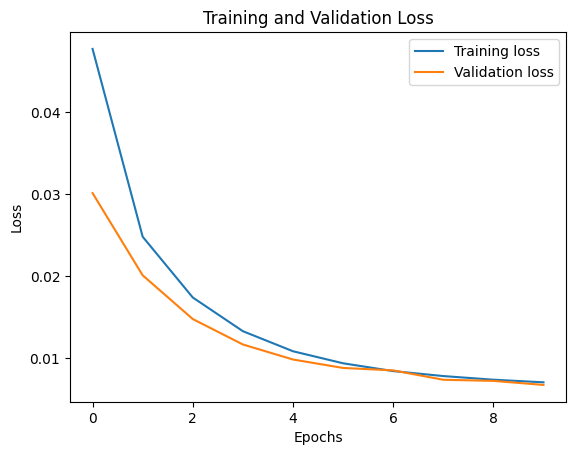

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


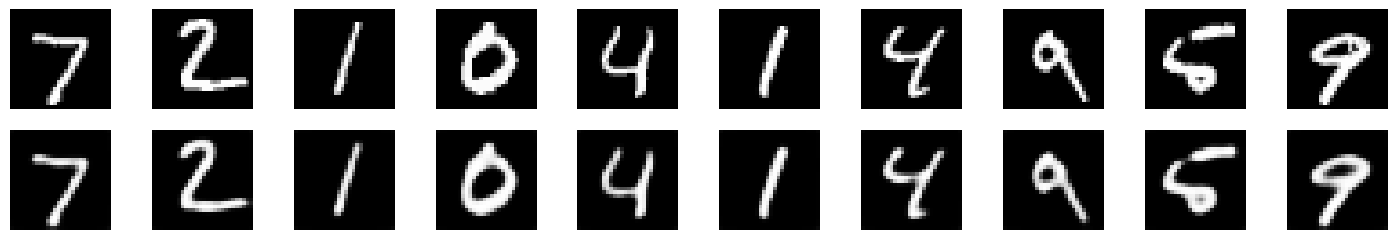

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_crossentropy: 0.0708 - loss: 0.0067
Metrics MAE: 0.0714154988527298, test loss: 0.006687914486974478
------------------------------------------------------------


In [ ]:

conv_ae = conv_autoencoder(interpolation='nearest')
training(conv_ae, x_train_mnist,  x_test_mnist)

### Apply Noise to the Images

In [ ]:
def add_noise_gaussian(images, noise_factor=0.3):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

def add_noise_salt_and_pepper(images, salt_prob=0.1, pepper_prob=0.1):
    noisy_images = np.copy(images)

    num_salt = np.ceil(salt_prob * images.shape[1] * images.shape[2])  # Num salt per image
    num_pepper = np.ceil(pepper_prob * images.shape[1] * images.shape[2])  # Num pepper per image

    for i in range(images.shape[0]):
        coords_salt = [np.random.randint(0, dim - 1, int(num_salt)) for dim in images[i, :, :, 0].shape]
        noisy_images[i][coords_salt[0], coords_salt[1], :] = 1

        coords_pepper = [np.random.randint(0, dim - 1, int(num_pepper)) for dim in images[i, :, :, 0].shape]
        noisy_images[i][coords_pepper[0], coords_pepper[1], :] = 0

    return noisy_images

def add_speckle_noise(image, mean=1, stddev=0.5):
    noise = np.random.normal(mean, stddev, image.shape)
    noisy_image = image + image * noise
    return np.clip(noisy_image, 0, 1)


In [ ]:
x_test_noisy_gaussian = add_noise_gaussian(x_test_mnist)

x_test_noisy_salt_and_pepper = add_noise_salt_and_pepper(x_test_mnist)

x_test_noisy_speckle = add_speckle_noise(x_test_mnist)


### Reconstruct Noisy Images Using Autoencoders

без BatchNormalization

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


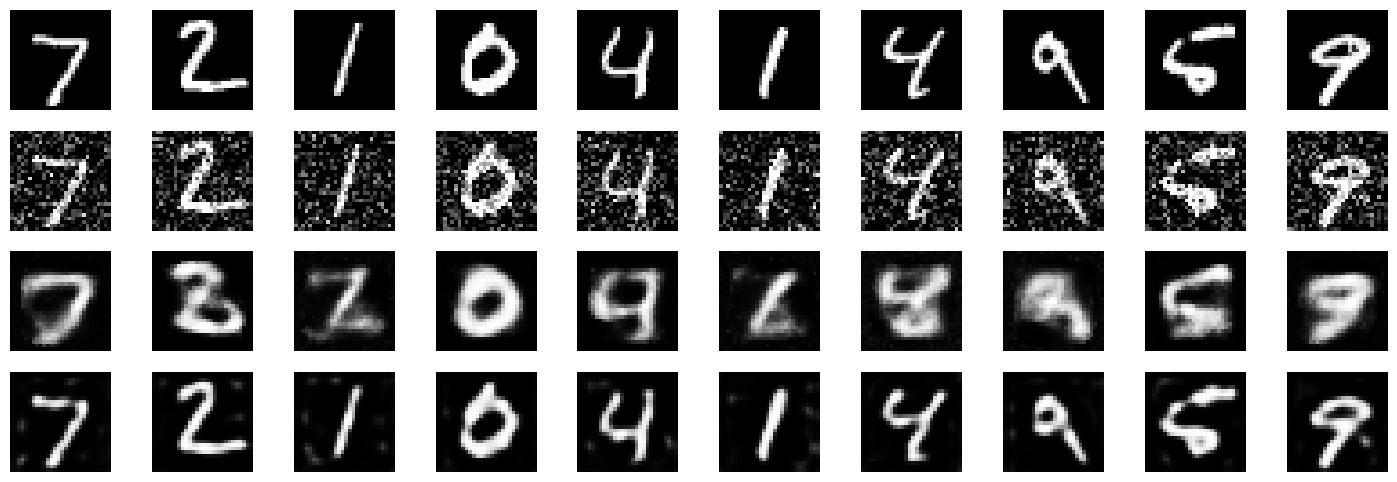

In [ ]:
reconstructed_images_deep = deep_ae.predict(x_test_noisy_gaussian)

reconstructed_images_conv = conv_ae.predict(x_test_noisy_gaussian)

plot_images(x_test_mnist, x_test_noisy_gaussian, reconstructed_images_deep,reconstructed_images_conv)


з BatchNormalization

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


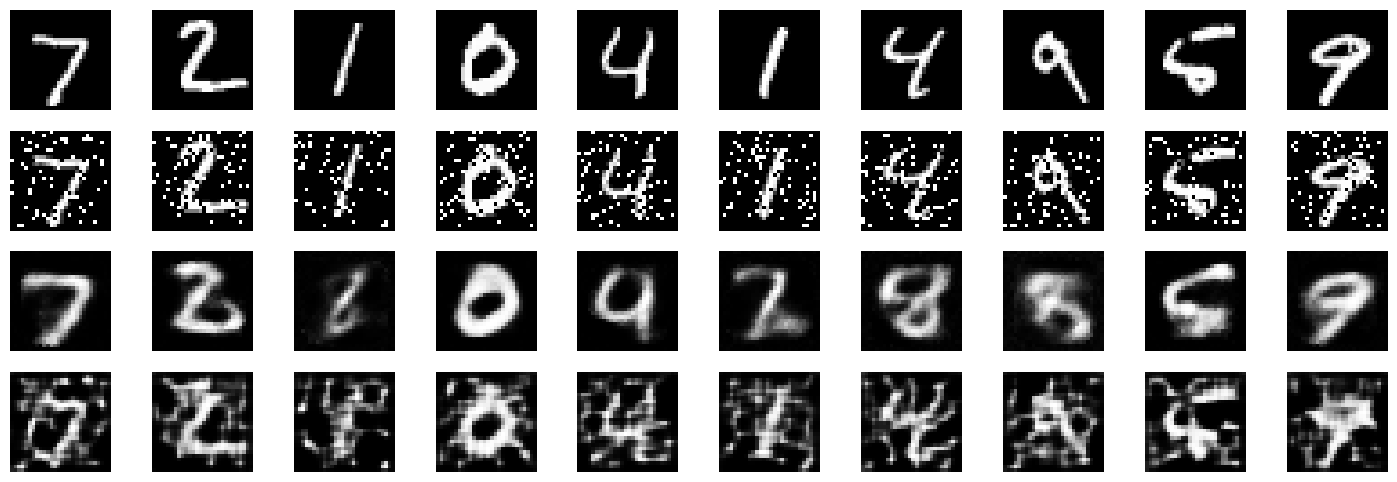

In [ ]:
reconstructed_images_deep = deep_ae.predict(x_test_noisy_salt_and_pepper)

reconstructed_images_conv = conv_ae.predict(x_test_noisy_salt_and_pepper)

plot_images(x_test_mnist, x_test_noisy_salt_and_pepper, reconstructed_images_deep,reconstructed_images_conv)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


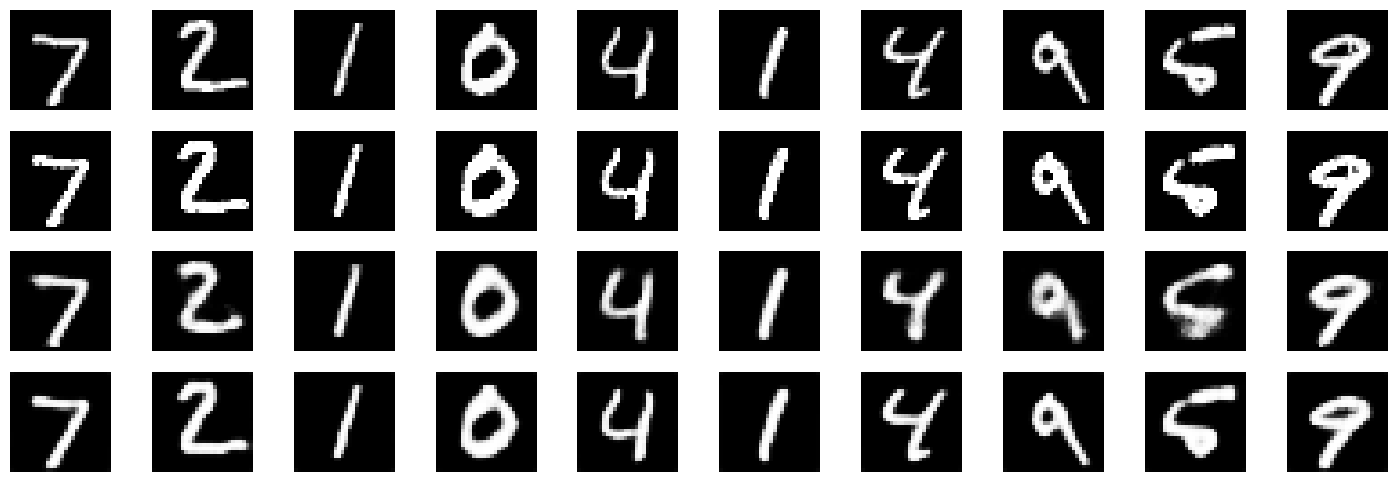

In [ ]:
reconstructed_images_deep = deep_ae.predict(x_test_noisy_speckle)

reconstructed_images_conv = conv_ae.predict(x_test_noisy_speckle)

plot_images(x_test_mnist, x_test_noisy_speckle, reconstructed_images_deep,reconstructed_images_conv)


## Fashion MNIST

### Deep Autoencoder (Fully Connected)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,153,712 (4.40 MB)

 Trainable params: 1,153,712 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

Training model CNN
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - binary_crossentropy: 0.4668 - loss: 0.0751 - val_binary_crossentropy: 0.3289 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.3213 - loss: 0.0258 - val_binary_crossentropy: 0.3127 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.3079 - loss: 0.0215 - val_binary_crossentropy: 0.3036 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.3002 - loss: 0.0190 - val_binary_crossentropy: 0.2993 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_crossentropy: 0.2959 - loss: 0.0176 - val_binary_crossentropy: 0.2964 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.2937 - loss: 0.0166 - val_binary_

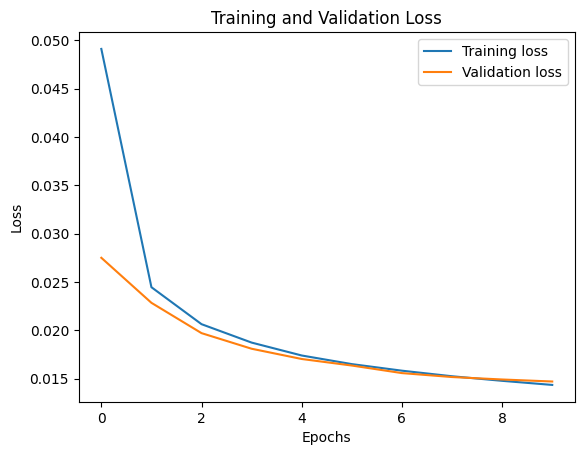

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


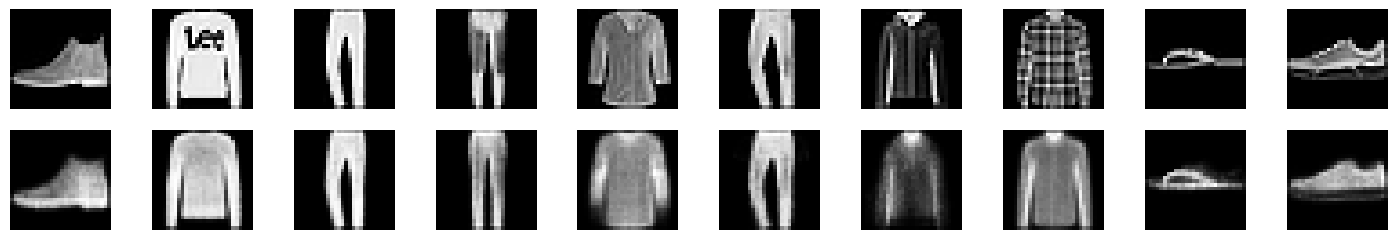

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.2886 - loss: 0.0146
Metrics MAE: 0.28903600573539734, test loss: 0.014696532860398293
------------------------------------------------------------


In [ ]:
fashion_deep_ae = deep_autoencoder()
training(fashion_deep_ae, x_train_fmnist,  x_test_fmnist)

### Convolutional Autoencoder

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_15 (UpSampling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,809 (186.75 KB)

 Trainable params: 47,617 (186.00 KB)

 Non-trainable params: 192 (768.00 B)

Training model CNN
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - binary_crossentropy: 0.3495 - loss: 0.0663 - val_binary_crossentropy: 0.3414 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - binary_crossentropy: 0.2717 - loss: 0.0304 - val_binary_crossentropy: 0.3278 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - binary_crossentropy: 0.2641 - loss: 0.0193 - val_binary_crossentropy: 0.3181 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - binary_crossentropy: 0.2609 - loss: 0.0134 - val_binary_crossentropy: 0.2947 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - binary_crossentropy: 0.2592 - loss: 0.0101 - val_binary_crossentropy: 0.2729 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - binary_crossentropy: 0.2579 - loss: 0.0084 - val_b

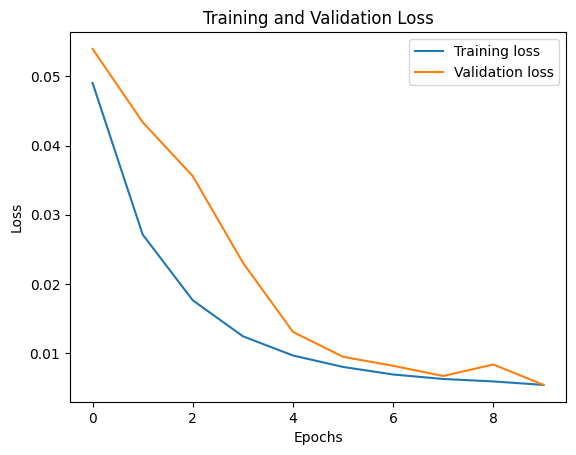

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


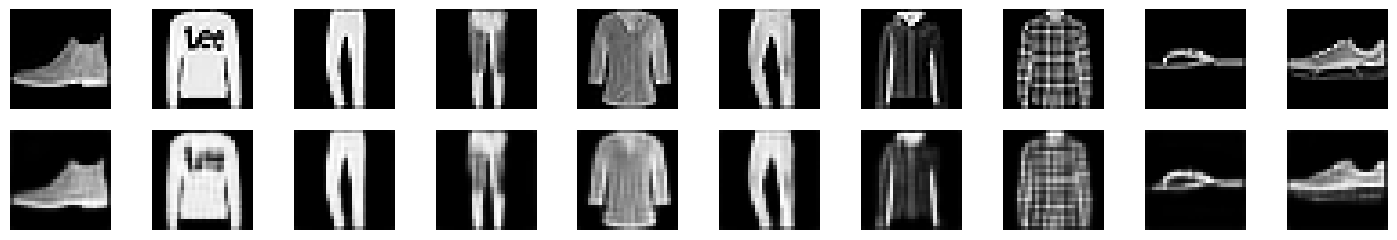

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_crossentropy: 0.2574 - loss: 0.0054
Metrics MAE: 0.25733375549316406, test loss: 0.005403390619903803
------------------------------------------------------------


In [ ]:
fashion_conv_ae = conv_autoencoder(interpolation='nearest')
training(fashion_conv_ae, x_train_fmnist,  x_test_fmnist)

### Apply Noise to the Images

In [ ]:
x_test_noisy_gaussian_fashion = add_noise_gaussian(x_test_fmnist)

x_test_noisy_salt_and_pepper_fashion = add_noise_salt_and_pepper(x_test_fmnist)

x_test_noisy_speckle_fashion = add_speckle_noise(x_test_fmnist)


### Reconstruct Noisy Images Using Autoencoders

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


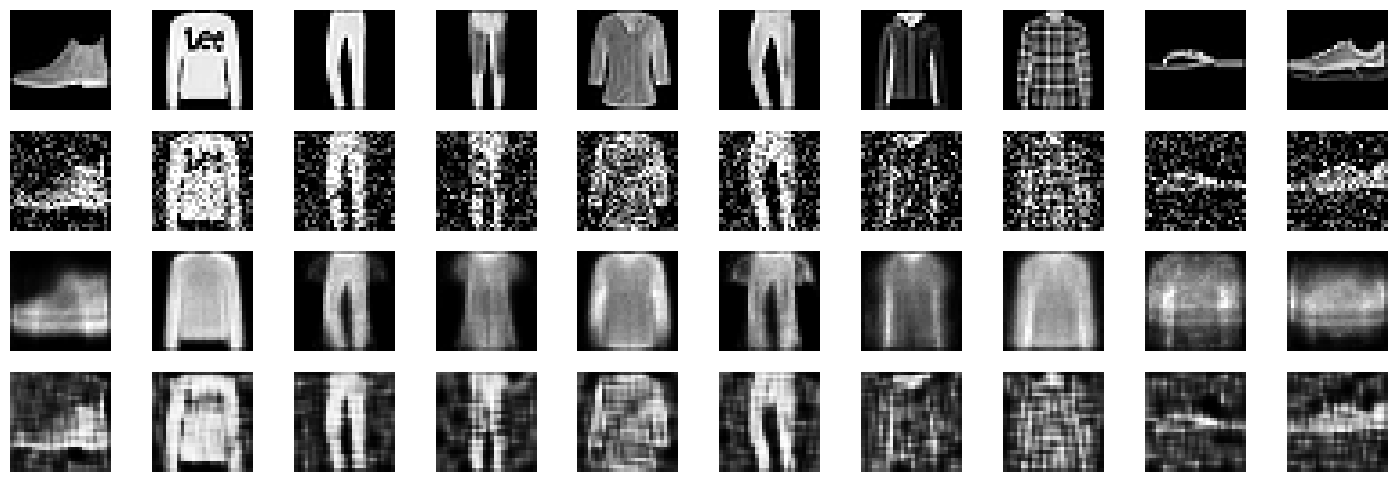

In [ ]:
reconstructed_images_deep = fashion_deep_ae.predict(x_test_noisy_gaussian_fashion)

reconstructed_images_conv = fashion_conv_ae.predict(x_test_noisy_gaussian_fashion)

plot_images(x_test_fmnist, x_test_noisy_gaussian_fashion, reconstructed_images_deep,reconstructed_images_conv)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


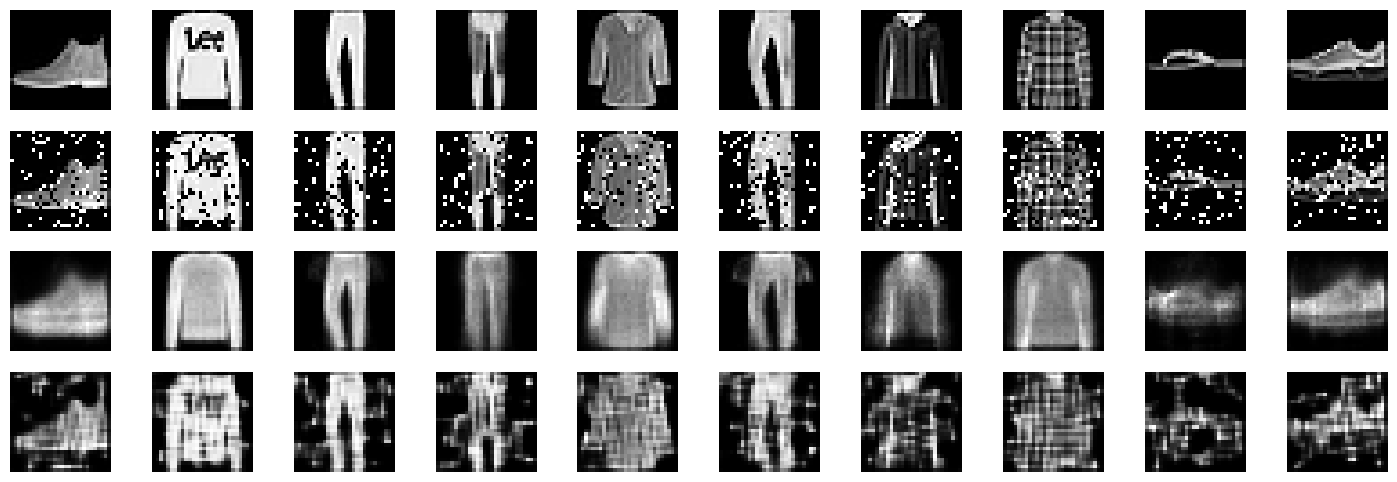

In [ ]:
reconstructed_images_deep = fashion_deep_ae.predict(x_test_noisy_salt_and_pepper_fashion)

reconstructed_images_conv = fashion_conv_ae.predict(x_test_noisy_salt_and_pepper_fashion)

plot_images(x_test_fmnist, x_test_noisy_salt_and_pepper_fashion, reconstructed_images_deep,reconstructed_images_conv)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


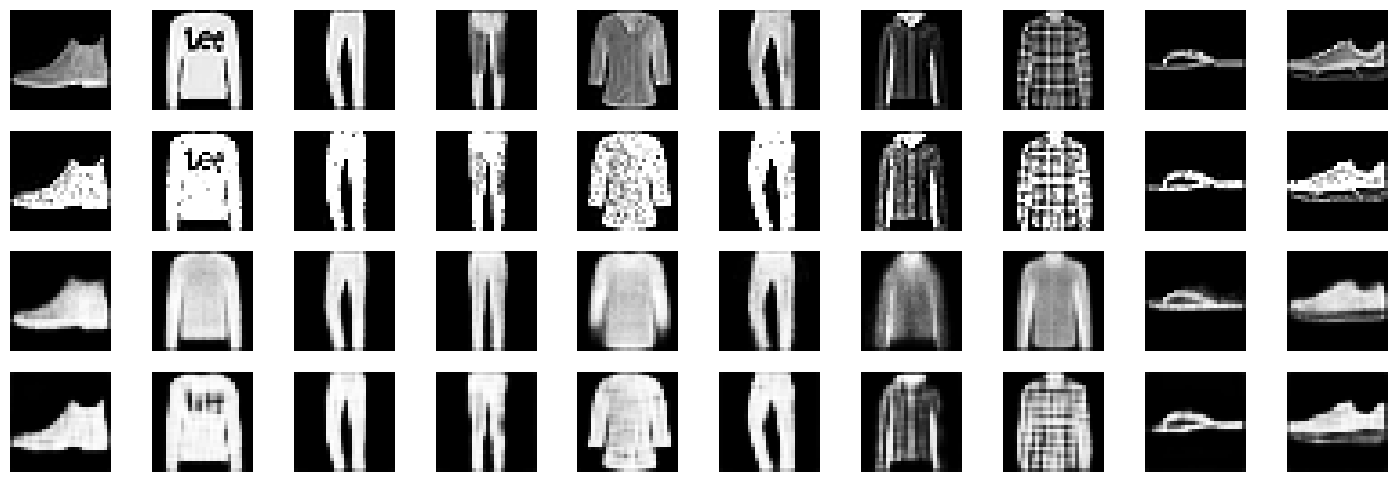

In [ ]:
reconstructed_images_deep = fashion_deep_ae.predict(x_test_noisy_speckle_fashion)

reconstructed_images_conv = fashion_conv_ae.predict(x_test_noisy_speckle_fashion)

plot_images(x_test_fmnist, x_test_noisy_speckle_fashion, reconstructed_images_deep,reconstructed_images_conv)


## Experiment зашумлені дані

In [ ]:
results = []
def training(autoencoder, train_X, train_Y,  X_test, epochs=10):
      print(f"Training model CNN")

      autoencoder.compile(optimizer='adam', loss='mse', metrics=['binary_crossentropy'])

      reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.5,
                                min_lr=1e-6)
      history = autoencoder.fit(train_X, train_Y,
                                epochs=epochs,
                                batch_size=256,
                                validation_data=(X_test, X_test),
                                callbacks=[reduce_lr])
      plot_visualization(history)
      predict_data = autoencoder.predict(X_test)
      plot_predict_images(X_test, predict_data)

      test_loss, metrics = autoencoder.evaluate(X_test, X_test)

      print(f"Metrics MAE: {metrics}, test loss: {test_loss}")
      log_model_info(autoencoder, epochs, history, test_loss, results)
      print("-" * 60)

In [ ]:
x_train_noisy = add_speckle_noise(add_noise_gaussian(x_train_fmnist, noise_factor=0.2), stddev=0.2)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,153,712 (4.40 MB)

 Trainable params: 1,153,712 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

Training model CNN
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - binary_crossentropy: 0.4622 - loss: 0.0749 - val_binary_crossentropy: 0.3421 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.3273 - loss: 0.0284 - val_binary_crossentropy: 0.3305 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.3148 - loss: 0.0244 - val_binary_crossentropy: 0.3286 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 4/10
223/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_crossentropy: 0.3088 - loss: 0.0224
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.3088 - loss: 0.0224 - val_binary_crossentropy: 0.3371 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 5/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.3042 - loss: 0.0204
Epoch 5: ReduceLROnPlatea

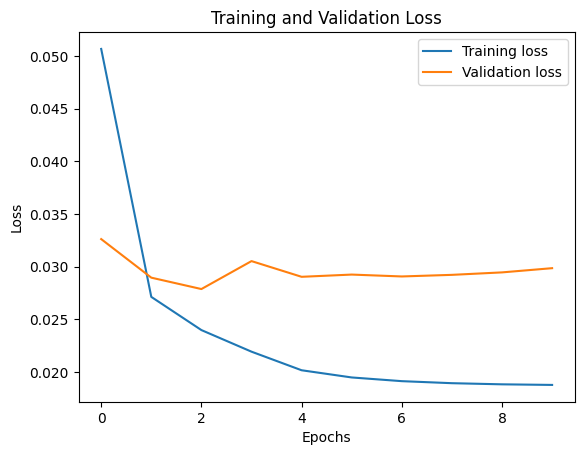

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


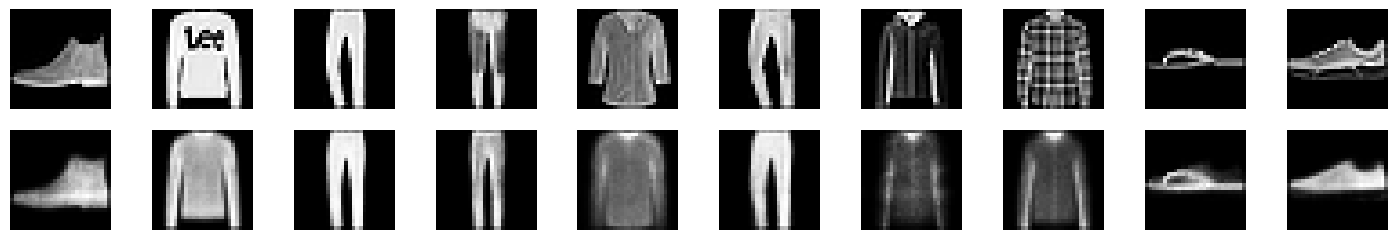

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_crossentropy: 0.3363 - loss: 0.0298
Metrics MAE: 0.3365749716758728, test loss: 0.029851971194148064
------------------------------------------------------------


In [ ]:
fashion_deep_ae = deep_autoencoder()
training(fashion_deep_ae, x_train_noisy, x_train_fmnist, x_test_fmnist)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_18 (UpSampling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_19 (UpSampling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,809 (186.75 KB)

 Trainable params: 47,617 (186.00 KB)

 Non-trainable params: 192 (768.00 B)

Training model CNN
Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - binary_crossentropy: 0.3721 - loss: 0.0757 - val_binary_crossentropy: 0.5113 - val_loss: 0.0837 - learning_rate: 0.0010
Epoch 2/15
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_crossentropy: 0.2915 - loss: 0.0410
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - binary_crossentropy: 0.2915 - loss: 0.0410 - val_binary_crossentropy: 0.6539 - val_loss: 0.1067 - learning_rate: 0.0010
Epoch 3/15
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_crossentropy: 0.2857 - loss: 0.0320
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - binary_crossentropy: 0.2857 - loss: 0.0320 - val_binary_crossentropy: 0.5770 - val_loss: 0.0932 - learning_rate: 5.0000e-04
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - binary_crossentropy: 0.2834 - loss: 0.0285 - val_binary_crossentropy: 

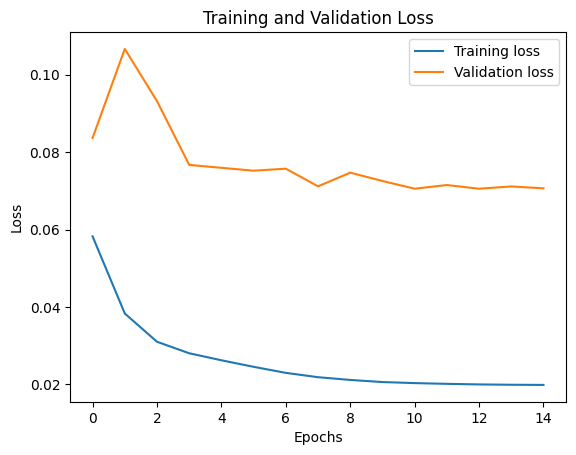

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


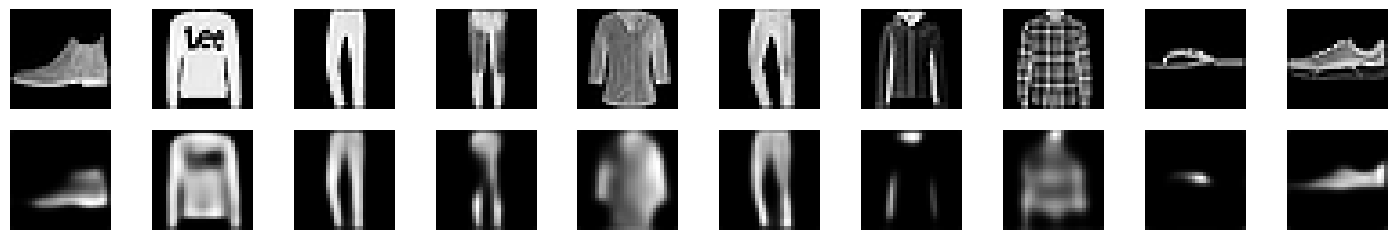

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_crossentropy: 0.4839 - loss: 0.0706
Metrics MAE: 0.4841005504131317, test loss: 0.07064363360404968
------------------------------------------------------------


In [ ]:

fashion_conv_ae = conv_autoencoder(interpolation='bilinear')
training(fashion_conv_ae, x_train_noisy, x_train_fmnist, x_test_fmnist, epochs = 15)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


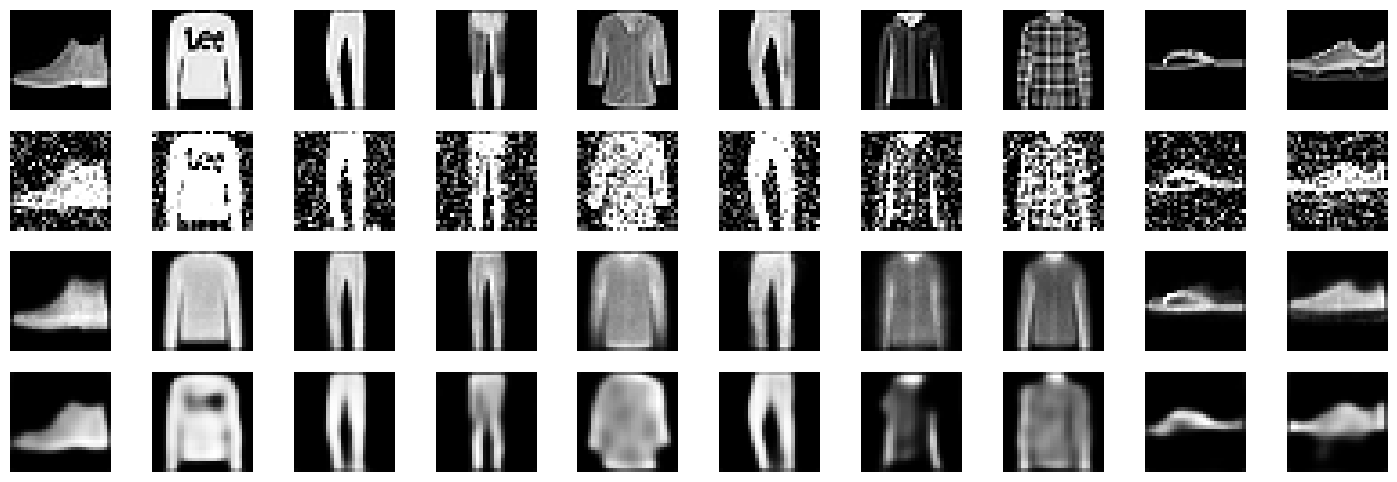

In [ ]:
x_test_noisy = add_speckle_noise(add_noise_gaussian(x_test_fmnist, noise_factor=0.2), stddev=0.2)
reconstructed_images_deep = fashion_deep_ae.predict(x_test_noisy)

reconstructed_images_conv = fashion_conv_ae.predict(x_test_noisy)

plot_images(x_test_fmnist, x_test_noisy, reconstructed_images_deep,reconstructed_images_conv)


# Висновки:
З пророблених експериментів навчання і тренування глибокого і конволюційного автоенкодера я дійшла до висновків що конволюційний автоенкодер краще справляється із зображеннями й краще передає деталі й обриси об'єктів зі всіма тюнінгами які були впроваджено.

Заодно була пророблена робота з навчанням моделей на зашумлених даних і це яскраво покращує передбачення результатів, якщо на вхід йде комбінація шумів на зображенні. Але в такому випадку глибокий автоенкодер дає чіткіші контурні зображення, ніж той самий конволюційний автоенкодер.